Импортируем все необходимые библиотеки (catboost почему то не завезли)

In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier


Загружаем датасет и удаляем сразу даты

In [55]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(columns=['ApplicationDate'])
test = test.drop(columns=['ApplicationDate'])

Функции для обработки данных, на этот раз стараемся не удалять в виду малого количества данных

In [56]:
def separate_target(df, target_col='LoanApproved'):
    """Разделяем целевую переменную от признаков."""
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])
    return X, y

def handle_missing_values(X):
    """Обработка пропусков:
    - Числовые: заполнение медианой
    - Категориальные: заполнение модой
    НЕ УДАЛЯЕМ, иначе будет мало данных, как было в прошлый раз
    """
    for col in X.columns:
        if X[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
            if X[col].notna().any():
                X[col] = X[col].fillna(X[col].median())
        else:
            if X[col].notna().any():
                X[col] = X[col].fillna(X[col].mode()[0])
    return X

def remove_outliers(X, factor=3.0):
    for col in X.select_dtypes(include=[np.number]).columns:
        mean = X[col].mean()
        std = X[col].std()
        lower_bound = mean - factor * std
        upper_bound = mean + factor * std

        median = X[col].median()
        X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), median, X[col])
    return X


def convert_bools_to_int(X):
    bool_cols = X.select_dtypes(include='bool').columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    return X

def encode_categorical(X, categorical_cols=None):
    if categorical_cols is None:
        categorical_cols = X.select_dtypes(include='object').columns.tolist()
    if not categorical_cols:
        return X

    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    cat_data = ohe.fit_transform(X[categorical_cols])
    cat_cols_new = ohe.get_feature_names_out(categorical_cols)

    X = X.drop(columns=categorical_cols)
    X = pd.concat([X, pd.DataFrame(cat_data, columns=cat_cols_new, index=X.index)], axis=1)
    return X

def scale_numeric(X):
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    return X

def clean_data(df, target_col='LoanApproved', categorical_cols=None):
    X, y = separate_target(df, target_col=target_col)
    y = y.fillna(y.median())  #для не самописных классификаторов
    X = handle_missing_values(X)
    X = remove_outliers(X)
    X = convert_bools_to_int(X)
    X = encode_categorical(X, categorical_cols=categorical_cols)
    X = scale_numeric(X)

    return X, y


Обучаем модель и бьем на части датасет

In [57]:
X_train, y_train = clean_data(train, target_col='LoanApproved', categorical_cols=['MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus', 'EducationLevel', 'LoanPurpose'])
X_test, y_test = clean_data(test, target_col='LoanApproved', categorical_cols=['MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus', 'EducationLevel', 'LoanPurpose'])

In [58]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Напишем класс линейного классификатора и логистической регрессии

In [62]:
import numpy as np

class MyLinearClassifier:
    def __init__(self, lr=0.01, n_iters=1000, reg_lambda=0.1):
        """
        Линейный классификатор с L2-регуляризацией.
        lr: скорость обучения
        n_iters: число итераций
        reg_lambda: коэффициент L2-регуляризации
        """
        self.lr = lr
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Обучение линейного классификатора.

        Модель: z = W·X + b
        Здесь W — вектор весов, b — смещение (скаляр), X — матрица признаков, y — истинные метки.

        Регуляризованный градиентный шаг учитывает L2-слагаемое:
        dw = (1/n)*Xᵀ(y - p) - (λ/n)*W
        db = (1/n)*∑(y - p)

        где p — вектор предсказанных вероятностей: p = σ(z)
        σ(z) = 1/(1+e⁻ᶻ) — сигмоидная функция, переводящая линейную комбинацию в вероятность.
        """
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for i in range(self.n_iters):
            # Линейная модель: z = W·X + b
            linear_model = np.dot(X, self.weights) + self.bias
            # Вероятности (сигмоид): p = σ(z)
            probabilities = self._sigmoid(linear_model)

            # Ошибка: y - p
            errors = y - probabilities

            # Градиенты для весов и смещения с учетом L2-регуляризации:
            # dw = (1/n)*Xᵀ(y - p) - (λ/n)*W
            # db = (1/n)*∑(y - p)
            dw = (1 / n_samples) * np.dot(X.T, errors) - (self.reg_lambda / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(errors)

            # Обновление параметров:
            self.weights += self.lr * dw
            self.bias += self.lr * db

            # Динамическое уменьшение шага обучения каждые 500 итераций
            if i > 0 and i % 500 == 0:
                self.lr *= 0.9

    def predict(self, X, threshold=0.5):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return np.where(probabilities >= threshold, 1, 0)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _compute_loss(self, y, probabilities):
        """
        Функция потерь (логистическая регрессия + L2-регуляризация):

        Без регуляризации:
        L = - (1/n)*∑[y·log(p) + (1-y)·log(1-p)]

        С L2-регуляризацией добавляем (λ/(2n))*∑W², что помогает избежать переобучения.
        """
        epsilon = 1e-15
        probabilities = np.clip(probabilities, epsilon, 1 - epsilon)
        loss = -np.mean(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))
        reg_term = (self.reg_lambda / (2 * len(y))) * np.sum(self.weights ** 2)
        return loss + reg_term


class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_predicted):
        """
        Логистическая функция потерь без регуляризации:
        L = - (1/n)*∑[y·log(p) + (1-y)·log(1-p)].
        """
        return -np.mean(y * np.log(y_predicted + 1e-15) + (1 - y) * np.log(1 - y_predicted + 1e-15))

    def fit(self, X, y, reg_lambda=0.1):
        """
        Обучение логистической регрессии с L2-регуляризацией:
        Отличие от MyLinearClassifier знак перед dw.
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Регуляризованный градиент:
            # Добавляем (λ/n)*W к градиенту по весам
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (reg_lambda / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.where(y_predicted >= 0.5, 1, 0)


Запустим самописные классификаторы

In [60]:
# Моя линейная модель
my_linear_clf = MyLinearClassifier()
my_linear_clf.fit(X_train_part, y_train_part)
y_pred_my_linear = my_linear_clf.predict(X_val)

# Моя логистическая регрессия
my_logreg = MyLogisticRegression()
my_logreg.fit(X_train_part, y_train_part)
y_pred_my_logreg = my_logreg.predict(X_val)

Воспользуемся библиотечными классификаторами

In [63]:
# LogisticRegression (sklearn)
sk_logreg = LogisticRegression(max_iter=1000)
sk_logreg.fit(X_train_part, y_train_part)
y_pred_sk_logreg = sk_logreg.predict(X_val)

# SVM
svm_clf = SVC()
svm_clf.fit(X_train_part, y_train_part)
y_pred_svm = svm_clf.predict(X_val)

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_part, y_train_part)
y_pred_dt = dt_clf.predict(X_val)

# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_part, y_train_part)
y_pred_rf = rf_clf.predict(X_val)

# Gradient Boosting (sklearn)
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_part, y_train_part)
y_pred_gb = gb_clf.predict(X_val)

# LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_part, y_train_part)
y_pred_lgb = lgb_clf.predict(X_val)

# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_part, y_train_part)
y_pred_xgb = xgb_clf.predict(X_val)

# CatBoost
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train_part, y_train_part)
y_pred_cat = cat_clf.predict(X_val)

# KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_part, y_train_part)
y_pred_knn = knn_clf.predict(X_val)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4710, number of negative: 4103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4831
[LightGBM] [Info] Number of data points in the train set: 8813, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534438 -> initscore=0.137969
[LightGBM] [Info] Start training from score 0.137969


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:01:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


После обучения всех моделей и предиктов, оцениваем их

Model: MyLinearClassifier
Accuracy: 0.9365, Precision: 0.9287, Recall: 0.9553, F1: 0.9419
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1017
         1.0       0.93      0.96      0.94      1187

    accuracy                           0.94      2204
   macro avg       0.94      0.93      0.94      2204
weighted avg       0.94      0.94      0.94      2204



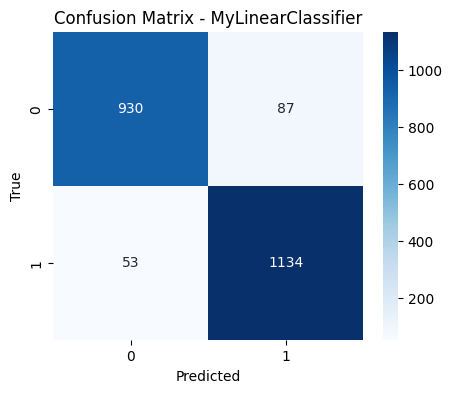

Model: MyLogisticRegression
Accuracy: 0.9378, Precision: 0.9303, Recall: 0.9562, F1: 0.9431
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      1017
         1.0       0.93      0.96      0.94      1187

    accuracy                           0.94      2204
   macro avg       0.94      0.94      0.94      2204
weighted avg       0.94      0.94      0.94      2204



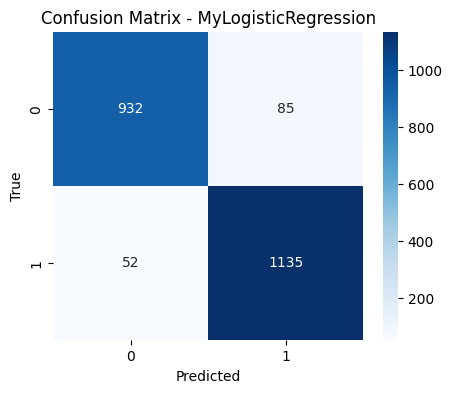

Model: SklearnLogisticRegression
Accuracy: 0.9769, Precision: 0.9773, Recall: 0.9798, F1: 0.9785
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1017
         1.0       0.98      0.98      0.98      1187

    accuracy                           0.98      2204
   macro avg       0.98      0.98      0.98      2204
weighted avg       0.98      0.98      0.98      2204



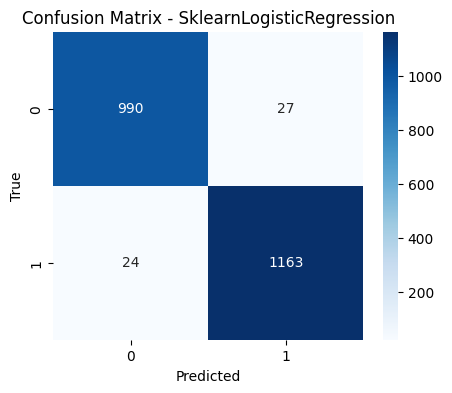

Model: SVM
Accuracy: 0.9746, Precision: 0.9756, Recall: 0.9773, F1: 0.9764
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1017
         1.0       0.98      0.98      0.98      1187

    accuracy                           0.97      2204
   macro avg       0.97      0.97      0.97      2204
weighted avg       0.97      0.97      0.97      2204



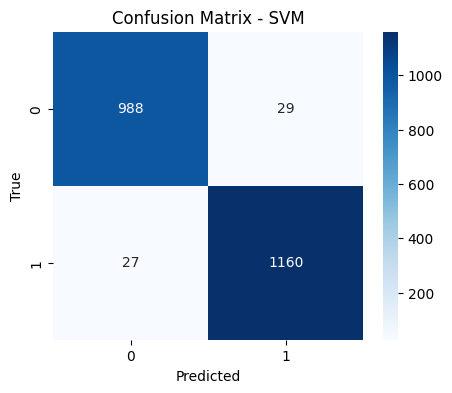

Model: DecisionTree
Accuracy: 0.9737, Precision: 0.9756, Recall: 0.9756, F1: 0.9756
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1017
         1.0       0.98      0.98      0.98      1187

    accuracy                           0.97      2204
   macro avg       0.97      0.97      0.97      2204
weighted avg       0.97      0.97      0.97      2204



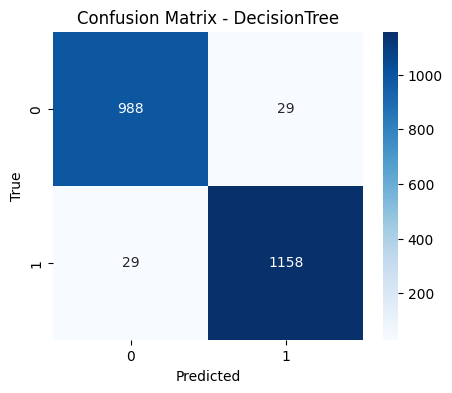

Model: RandomForest
Accuracy: 0.9760, Precision: 0.9789, Recall: 0.9764, F1: 0.9776
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1017
         1.0       0.98      0.98      0.98      1187

    accuracy                           0.98      2204
   macro avg       0.98      0.98      0.98      2204
weighted avg       0.98      0.98      0.98      2204



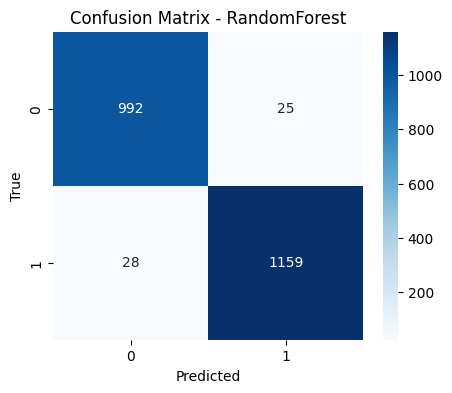

Model: GradientBoosting (sklearn)
Accuracy: 0.9796, Precision: 0.9790, Recall: 0.9832, F1: 0.9811
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1017
         1.0       0.98      0.98      0.98      1187

    accuracy                           0.98      2204
   macro avg       0.98      0.98      0.98      2204
weighted avg       0.98      0.98      0.98      2204



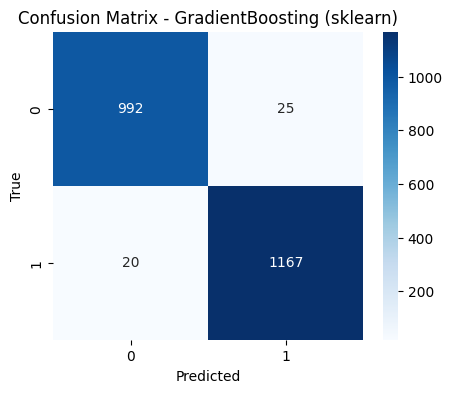

Model: LightGBM
Accuracy: 0.9891, Precision: 0.9899, Recall: 0.9899, F1: 0.9899
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1017
         1.0       0.99      0.99      0.99      1187

    accuracy                           0.99      2204
   macro avg       0.99      0.99      0.99      2204
weighted avg       0.99      0.99      0.99      2204



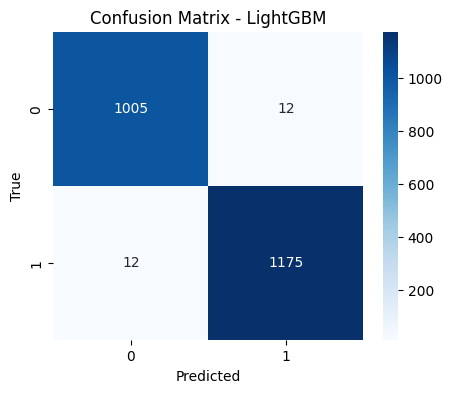

Model: XGBoost
Accuracy: 0.9877, Precision: 0.9907, Recall: 0.9865, F1: 0.9886
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1017
         1.0       0.99      0.99      0.99      1187

    accuracy                           0.99      2204
   macro avg       0.99      0.99      0.99      2204
weighted avg       0.99      0.99      0.99      2204



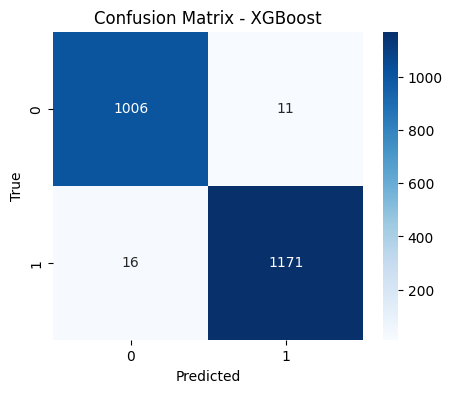

Model: CatBoost
Accuracy: 0.9868, Precision: 0.9882, Recall: 0.9874, F1: 0.9878
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1017
         1.0       0.99      0.99      0.99      1187

    accuracy                           0.99      2204
   macro avg       0.99      0.99      0.99      2204
weighted avg       0.99      0.99      0.99      2204



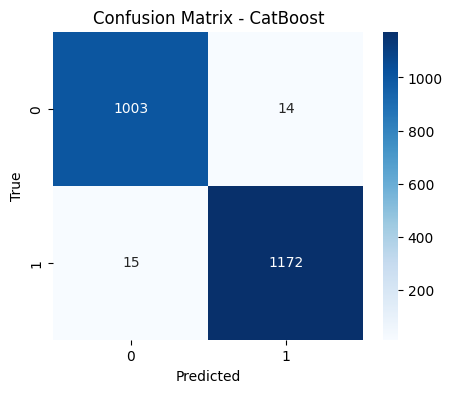

Model: KNN
Accuracy: 0.8961, Precision: 0.8939, Recall: 0.9158, F1: 0.9047
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      1017
         1.0       0.89      0.92      0.90      1187

    accuracy                           0.90      2204
   macro avg       0.90      0.89      0.90      2204
weighted avg       0.90      0.90      0.90      2204



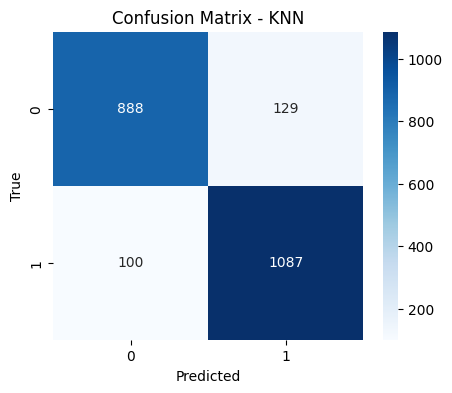

In [61]:
models_preds = {
    "MyLinearClassifier": y_pred_my_linear,
    "MyLogisticRegression": y_pred_my_logreg,
    "SklearnLogisticRegression": y_pred_sk_logreg,
    "SVM": y_pred_svm,
    "DecisionTree": y_pred_dt,
    "RandomForest": y_pred_rf,
    "GradientBoosting (sklearn)": y_pred_gb,
    "LightGBM": y_pred_lgb,
    "XGBoost": y_pred_xgb,
    "CatBoost": y_pred_cat,
    "KNN": y_pred_knn
}

for model_name, y_pred in models_preds.items():
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


**Выводы:**  
   Все представленные модели показали достаточно высокое качество, а точность (accuracy) большинства решений превысила 0.9. Однако среди моделей есть явные лидеры и модели, показывающие чуть более скромные результаты.

**Свои классификаторы:**
   Мои собственные реализации линейного классификатора и логистической регрессии продемонстрировали точность около 0.94, что, полагаю, является хорошим результатом для самописных решений. Правда там используется обновление весов и **L-2** регуляризация.
  

**Модели SVM, DecisionTree, RandomForest:**
   **SVM**, **DecisionTree**, **RandomForest** продемонстрировали результаты сходного уровня: около 0.97–0.98 по accuracy и F1 около 0.97–0.98. Это говорит о том, что с задачей они справились. DecisionTree хоть и склонно к переобучению, но здесь, видимо, данные и параметры подобраны так, что этого не произошло.

**Библиотеки и фреймворки:**
   **GradientBoosting (sklearn)** повысил точность и F1-меру примерно до 0.98, что ещё лучше. **LightGBM**, **XGBoost** и **CatBoost**, как современные фреймворки показали лучшие результаты.

**KNN (k-ближайших соседей):**
   **KNN** продемонстрировал наименее впечатляющий результат по сравнению с остальными методами: accuracy около 0.896 и F1 около 0.90. Это всё ещё неплохо, но заметно хуже, чем у бустинговых моделей.

**Выбор наилучшей модели и наиболее информативной метрики:**
   По цифрам метрик, лидирующей моделью стала **LightGBM**. За ней идут остальные фреймворки. В условиях, когда обе метрики (precision и recall) высокие и сбалансированы, **F1-мера** становится наиболее показательным критерием. Она сводит в единое число баланс между точностью и полнотой.
